#  Grafos y redes de transporte

# Clase 4

##  Parte 4. OSMnx II
### Topología de une red de calles
#### Algunos conceptos básicos

Los nodos de OpenStreetMap no sólo contemplan intersecciones. También suelen incluir puntos que no cumplen ninguna función en el sentido estricto de la teoría de grafos. Como por ejemplo, puntos en curvaturas de calles. Al decir que no cumplen ninguna función, no estamos diciendo otra cosa que no son nodos y como tales no forman parte de nuestra red. Sí corresponden a algún segmento de un eje, pero que necesita ser simplificado. 

In [1]:
import pandas as pd
import geopandas as gpd
import osmnx as ox
%matplotlib inline
ox.__version__
print(ox.__version__)
ox.config(log_file=True, log_console=True, use_cache=True)

1.0.1


# 1. Simplificando la red

In [2]:
# creamos una red a partir de un set de coordenadas
referencia = (-34.50944,-58.58610)
G = ox.graph_from_point(referencia, network_type='walk', dist=500, simplify=False)

In [3]:
# el método "simplifiy_graph" elimina los nodos que no son un endpoint
nc = ['r' if ox.simplification._is_endpoint(G, node) else 'y' for node in G.nodes()]

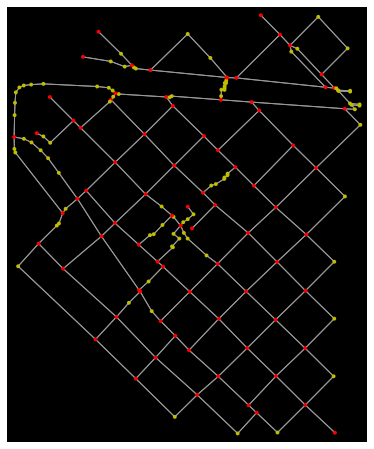

In [4]:
fig, ax = ox.plot_graph(G, bgcolor='black', node_color=nc)

Detengámonos dos segundos a ver qué pasó acá. En primer lugar, el atributo `nodo` de nuestra red parece ser un iterable. Veamos qué tipo de objeto es ...

In [5]:
# ya vemos que los nodos se definen a partir de clases de la librería netwrokx
type(G.nodes())

networkx.classes.reportviews.NodeView

En nuestro caso, notamos con ...

In [6]:
len(G.nodes())

169

In [7]:
# y ...
len(G.edges())

430

Vemoas qué sucede si accedemos al primer nodo de nuestra lista y lo evaluamos con el método `_is_endpoint`

In [8]:
ox.simplification._is_endpoint(G, list(G.nodes())[0])

True

Esto nos devuelve un booleano, lo cual nos permite apelar a una lista por comprensión para obtener los colores que se le va a asignar a cada eje.

### Ejercitación: 

Cómo harían para disponer los nodos y los ejes de manera relacional? Es decir, saber que los pares de ejes corresponden a tal o cual nodos?

In [9]:
def arma_ejes(x):
    for i in G.edges():
        if x in i:
            return i
        else:
            pass

Vamos a remover los puntos amarillos, ya que no son nodos en si mismos.

In [10]:
ejes = pd.Series(list(G.nodes())).map(arma_ejes)

In [11]:
ejes.head()

0    (333739864, 333739879)
1    (333739873, 333739885)
2    (333739864, 333739879)
3    (333739873, 333739885)
4    (333739873, 333739888)
dtype: object

In [12]:
grafo_df = pd.DataFrame({'nodos':list(G.nodes()), 'ejes':ejes})

In [13]:
grafo_dict = dict(zip(grafo_df.nodos, grafo_df.ejes))

In [14]:
# así podríamos acceder a un par de ejes por alguno de sus nodos
grafo_dict[333739864]

(333739864, 333739879)

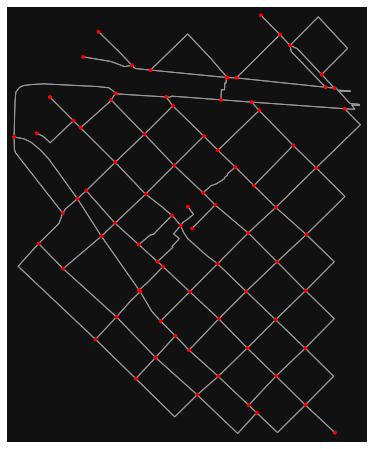

In [15]:
# ahora sí, simplificamos la red y la ploteamos. Vemos que los nodos amarillos desaparecieron. 
# Nos quedamos solamente con los end points 
G = ox.simplify_graph(G)
fig, ax = ox.plot_graph(G, node_color='r')

# 2. Características de la red (ejes)

De todas manera, OSMNx cuenta con sus propios métodos para estructurar una red con nodos y arcos sin tener que recurrir a pandas o estructuras de python nativo. En esta sección vamos a ver cómo caracterizar una red en función de sus atributos, tanto a trabajando con la clase `graph` de `networkx` como reestructurando el grafo como un geodataframe.

In [16]:
# primero, recordemos que estamos trabajando con un grafo dirigido de ambos sentidos
type(G)

networkx.classes.multidigraph.MultiDiGraph

## 2.1. Largo de calles

Algo muy útil de OSMNx es que te permite calcular colores por atributos. En este caso, veamos cómo funciona con el largo de las calles (o ejes de nuestro grafo)...

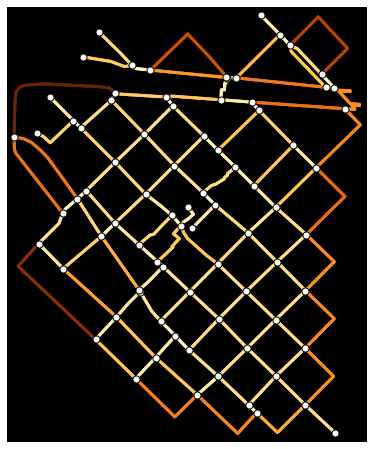

In [17]:
# este método pertenece al módulo plot
largo_ejes = ox.plot.get_edge_colors_by_attr(G, attr='length', cmap='YlOrBr')
fig, ax = ox.plot_graph(G, bgcolor='black', node_color='w', node_edgecolor='k', node_size=50,
                        edge_color=largo_ejes, edge_linewidth=3)

Podemos ver que este método nos devuelve un set ordenado de datos de tipo ...

In [18]:
# Serie, de pandas
type(largo_ejes)

pandas.core.series.Series

In [19]:
largo_ejes

333739864   333739879   0    (0.996078431372549, 0.8701730103806228, 0.5259...
            684355680   0    (0.9997385620915032, 0.9633986928104575, 0.726...
            684355692   0    (0.9965397923875433, 0.8994232987312571, 0.588...
333739873   333739885   0    (0.996078431372549, 0.8549173394848135, 0.4935...
            333739959   0    (0.9961707035755479, 0.8920415224913494, 0.572...
                                                   ...                        
8075787784  684348010   0    (0.996078431372549, 0.7786389850057671, 0.3311...
            8075787786  0    (0.9985082660515187, 0.938792772010765, 0.6731...
8075787786  684325432   0    (0.9927566320645905, 0.5924336793540945, 0.156...
            684325441   0                  (1.0, 1.0, 0.8980392156862745, 1.0)
            8075787784  0    (0.9985082660515187, 0.938792772010765, 0.6731...
Length: 252, dtype: object

Esto representa a cada uno de los nodos con sus respectivas conexiones. Así quedan armados los ejes, a los cuales podemos acceder indexando por el id de los extremos. 

In [20]:
# acá el código con el color asigando
largo_ejes[333739864][333739879][0]

(0.996078431372549, 0.8701730103806228, 0.5259976931949251, 1.0)

## 2.2. Ejes múltiple o paralelos

En primer lugar, recordemos que estamos trabajando con la clase [multidigraph](https://networkx.org/documentation/networkx-1.10/reference/classes.multidigraph.html). Es decir, un grafo dirigido. En este tipo de estructuras, se llaman [ejes múltiples o paralelos](https://en.wikipedia.org/wiki/Multiple_edges) a aquellos que comparten los vértices  nodos de inicio y fin. 

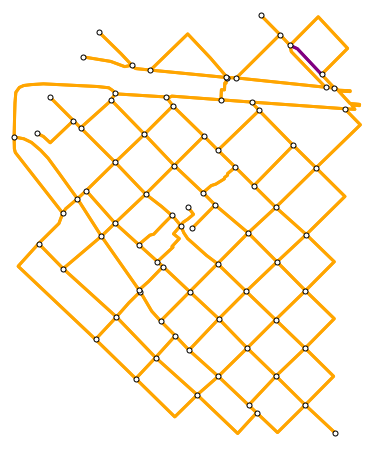

In [21]:
colores = ['orange' if k == 0 or u == v else 'purple' for u, v, k in G.edges(keys=True)]
fig, ax = ox.plot_graph(G, node_color='white', bgcolor='white', node_edgecolor='k', node_size=25,
                        edge_color=colores, edge_linewidth=3)

In [22]:
# vemos los ejes que estan repetidos, normalmente deberian tener los mismos nodos invertidos
for i, e in enumerate(list(G.edges())[:-1]):
    if e == list(G.edges())[i+1]:
        print('index:{}'.format(i))
        print(list(G.edges(keys=True))[i:i+2])

index:88
[(684325442, 6853027363, 0), (684325442, 6853027363, 1)]
index:237
[(6853027363, 684325442, 0), (6853027363, 684325442, 1)]


In [23]:
# efectivamente, tenemos un par de ejes que son parelelos o multiples
pd.Series(colores).value_counts()

orange    250
purple      2
dtype: int64

Esto mismo, podríamos haberlo contrastado si tratábamos nuestro grafo como un GeoDataFrame de Geopandas. El método `graph_to_gdfs` nos permite pasar de una objeto de tipo grafo a otro de esquema tabular.

In [24]:
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)

In [25]:
gdf_edges.head()

osmid  oneway              name      highway  \
u         v         key                                                    
333739864 333739879 0    30281552   False   226 - El Zorzal  residential   
          684355680 0    30281576   False  37 - José Madero  residential   
          684355692 0    54266580   False       José Madero  residential   
333739873 333739885 0    30281552   False   226 - El Zorzal  residential   
          333739959 0    30281552   False   226 - El Zorzal  residential   

                        maxspeed   length  \
u         v         key                     
333739864 333739879 0         40   95.594   
          684355680 0        NaN   48.087   
          684355692 0        NaN   83.178   
333739873 333739885 0         40  100.504   
          333739959 0         40   86.943   

                                                                  geometry  \
u         v         key                                                      
333739864 333739879 0    LINESTRING (-58.58570 -34.51133, -58.58496 -34...   
          684355680 0    LINESTRING (-58.58570 -34.51133, -58.58533 -34...   
          684355692 0    LINESTRING (-58.58570 -34.51133, -58.58592 -34...   
333739873 333739885 0    LINESTRING (-58.58349 -34.50950, -58.58426 -34...   
          333739959 0    LINESTRING (-58.58349 -34.50950, -58.58279 -34...   

                        lanes  ref tunnel service  
u         v         key                            
333739864 333739879 0     NaN  NaN    NaN     NaN  
          684355680 0     NaN  NaN    NaN     NaN  
          684355692 0     NaN  NaN    NaN     NaN  
333739873 333739885 0     NaN  NaN    NaN     NaN  
          333739959 0     NaN  NaN    NaN     NaN

In [26]:
gdf_nodes.head()

,y,x,street_count,geometry
osmid,,,,
333739864,-34.511334,-58.585700,3,POINT (-58.58570 -34.51133)
333739873,-34.509501,-58.583489,4,POINT (-58.58349 -34.50950)
333739879,-34.510725,-58.584964,4,POINT (-58.58496 -34.51072)
333739885,-34.510142,-58.584262,4,POINT (-58.58426 -34.51014)
333739888,-34.510104,-58.582761,4,POINT (-58.58276 -34.51010)


In [27]:
import matplotlib.pyplot as plt

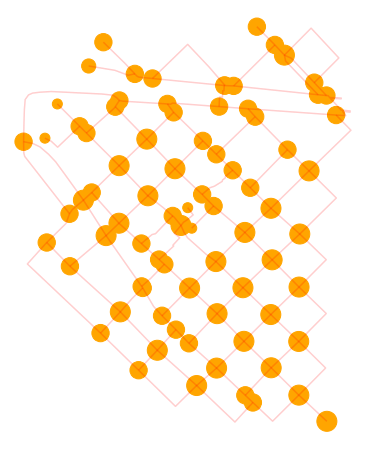

In [28]:
f, ax = plt.subplots(figsize=(12,8))
gdf_edges.plot(ax=ax, color='red', linewidth=1.5, alpha=0.1)
gdf_nodes.plot(ax=ax, color='orange', markersize=gdf_nodes.street_count * 100) # graduamos el nodo!

ax.set_axis_off();

Ahora busquemos nuestros ejes múltiples en el geodataframe de ejes. Podemos ver que ambos ejes son idénticos, pero con el inicio/fin (nodos) invertido.

In [29]:
gdf_edges.iloc[88:90]#.plot()

osmid  oneway  \
u         v          key                                           
684325442 6853027363 0    [54264599, 53126381, 47413135]   False   
                     1                         731815694   False   

                                                                 name  \
u         v          key                                                
684325442 6853027363 0    [Carlos Gardel, Manuel Lainez, 14 de Julio]   
                     1                             Manuel de Sarratea   

                              highway maxspeed   length  \
u         v          key                                  
684325442 6853027363 0    residential       40  277.626   
                     1    residential      NaN  100.475   

                                                                   geometry  \
u         v          key                                                      
684325442 6853027363 0    LINESTRING (-58.58243 -34.50560, -58.58172 -34...   
                     1    LINESTRING (-58.58243 -34.50560, -58.58225 -34...   

                         lanes  ref tunnel service  
u         v          key                            
684325442 6853027363 0     NaN  NaN    NaN     NaN  
                     1     NaN  NaN    NaN     NaN

In [30]:
gdf_edges.iloc[237:239]#.plot()

osmid  oneway  \
u          v         key                                           
6853027363 684325442 0    [47413135, 53126381, 54264599]   False   
                     1                         731815694   False   

                                                                 name  \
u          v         key                                                
6853027363 684325442 0    [Carlos Gardel, Manuel Lainez, 14 de Julio]   
                     1                             Manuel de Sarratea   

                              highway maxspeed   length  \
u          v         key                                  
6853027363 684325442 0    residential       40  277.626   
                     1    residential      NaN  100.475   

                                                                   geometry  \
u          v         key                                                      
6853027363 684325442 0    LINESTRING (-58.58164 -34.50621, -58.58098 -34...   
                     1    LINESTRING (-58.58164 -34.50621, -58.58225 -34...   

                         lanes  ref tunnel service  
u          v         key                            
6853027363 684325442 0     NaN  NaN    NaN     NaN  
                     1     NaN  NaN    NaN     NaN

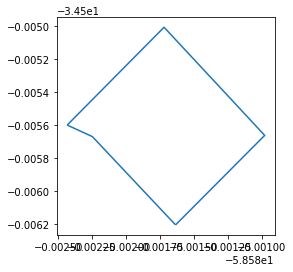

In [31]:
gdf_edges.iloc[88:90].plot();

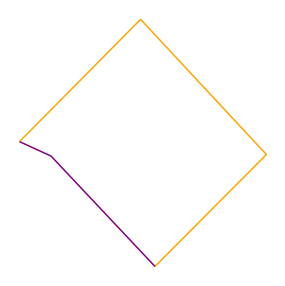

In [32]:
f, ax = plt.subplots(figsize=(9,5))
gdf_edges.iloc[88:90].iloc[0:1].plot(ax=ax, color='orange') # eje 1
gdf_edges.iloc[88:90].iloc[1:2].plot(ax=ax, color='purple') # eje 2
ax.set_axis_off();

## 2.3. Calles de sentido único

In [33]:
barrios = gpd.read_file('../carto/renabap.geojson')

# nos quedamos con los barrios de San Martin
barrios_sm = barrios.loc[(barrios.provincia == 'Buenos Aires') & (barrios.departamen == 'General San Martín')]

In [34]:
# y ahora con algunos de jose leon suarez
barrios_ls = barrios_sm.loc[(barrios_sm.nombre_bar == 'Villa Hidalgo')|
                            (barrios_sm.nombre_bar == 'La Carcova')].copy()

In [35]:
# La Carcova
lc = barrios_ls['geometry'].iloc[1]

In [36]:
G2 = ox.graph_from_polygon(lc, network_type='drive_service')

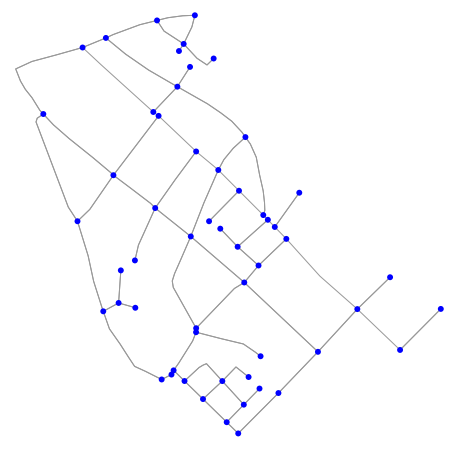

In [37]:
fig, ax = ox.plot_graph(G2, bgcolor='white', node_color='blue', node_size=35)

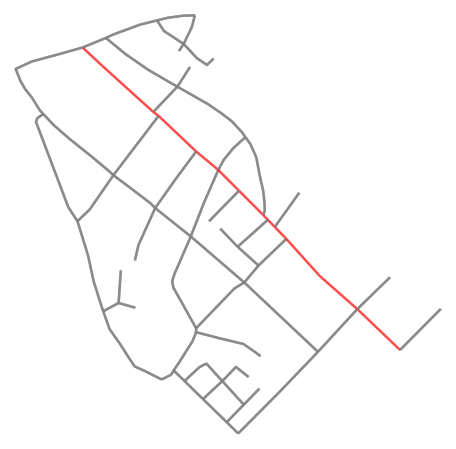

In [38]:
# veamos ahora cuales son las calles de sentido unico
colores = ['red' if data['oneway'] else 'grey' for u, v, key, data in G2.edges(keys=True, data=True)]
fig, ax = ox.plot_graph(G2, node_size=0, bgcolor='white', edge_color=colores, edge_linewidth=2.5, edge_alpha=0.7)

Antes, vimos que el parametro `keys` nos devolvía los nodos de un eje, ahora podemos apreciar que con `data` conseguimos información adicional, como el nombre o la direccionalidad de nuestra calle.

In [39]:
list(G2.edges(keys=True, data=True))[3:5]

[(684364421,
  684364414,
  0,
  {'osmid': 54266791,
   'oneway': True,
   'name': '51 - 1° de Mayo',
   'highway': 'residential',
   'maxspeed': '40',
   'length': 171.62199999999999,
   'geometry': <shapely.geometry.linestring.LineString at 0x7f3b00cf1910>}),
 (684364466,
  684376350,
  0,
  {'osmid': 467058948,
   'name': '192 - Fray Luis Beltrán',
   'highway': 'residential',
   'maxspeed': '40',
   'oneway': False,
   'length': 103.683})]

# 3. Métricas de una red

## 3.1. Estadísticas de base

OSMNx también cuenta con el método `basic_stats`. Este nos da un pantallazo acerca de la topología de la red, con métricas como la cantidad de nodos y ejes, el largo total de las calles, etc. 

In [40]:
# calculamos métricas de base
stats = ox.basic_stats(G)

In [41]:
# que vemos se almacenan en un diccionario
stats.keys()

dict_keys(['n', 'm', 'k_avg', 'intersection_count', 'streets_per_node_avg', 'streets_per_node_counts', 'streets_per_node_proportion', 'edge_length_total', 'edge_length_avg', 'street_length_total', 'street_length_avg', 'street_segments_count', 'node_density_km', 'intersection_density_km', 'edge_density_km', 'street_density_km', 'circuity_avg', 'self_loop_proportion', 'clean_intersection_count', 'clean_intersection_density_km'])

In [42]:
stats

{'n': 80,
 'm': 252,
 'k_avg': 6.3,
 'intersection_count': 76,
 'streets_per_node_avg': 3.25,
 'streets_per_node_counts': {0: 0, 1: 4, 2: 1, 3: 46, 4: 29},
 'streets_per_node_proportion': {0: 0.0,
  1: 0.05,
  2: 0.0125,
  3: 0.575,
  4: 0.3625},
 'edge_length_total': 25957.928000000007,
 'edge_length_avg': 103.00765079365082,
 'street_length_total': 12978.964000000004,
 'street_length_avg': 103.00765079365082,
 'street_segments_count': 126,
 'node_density_km': None,
 'intersection_density_km': None,
 'edge_density_km': None,
 'street_density_km': None,
 'circuity_avg': 1.0880779040632504,
 'self_loop_proportion': 0.0,
 'clean_intersection_count': None,
 'clean_intersection_density_km': None}

In [43]:
# al que podemos acceder como en cualquier diccionario, por ejemplo el largo promedio de las calles
stats['street_length_avg']

103.00765079365082

### Resúmen de métricas del módulo [stats](https://github.com/gboeing/osmnx/blob/master/osmnx/stats.py): 

* n = cantidad de nodos en el grafo
* m = cantidad de ejes en el grafo
* k_avg = grado promedio de los nodos en el grafo (promedio de conexiones o cantidad de vecinos con los que conecta un nodo dentro de la red)
* intersection_count = cantidad de intersecciones en el grafo (nodos intersectando con más de una calle) 
* streets_per_node_avg = cantidad de calles (o ejes) con las que conecta cada nodo, en promedio, dentro de la red.
* streets_per_node_counts = diccionario con la cantidad de calles conectando con un nodo (keys), y el numero total de nodos para dicha cantidad (values). 
* streets_per_node_proportion = idem. pero con proporciones. Las sumas de los 'values' alcanzan el 100%.
* edge_length_total = suma del largo de los ejes en el grafo (en metros)
* edge_length_avg = promedio del largo de los ejes en el grafo (en metros)
* street_length_total = suma del largo de todos los ejes en la representación no dirigida del grafo (en metros)
* street_length_avg = promedio del largo de los ejes en la representación no dirigida del grafo (en metros)
* street_segments_count = cantidad de ejes en la representación no dirigida del grafo
* node_density_km = n dividido por el área en km2
* intersection_density_km = intersection_count dividido por el area en km2
* edge_density_km = edge_length_total dividido por el área en km2
* street_density_km = street_length_total dividido por el área en km2
* circuity_avg = edge_length_total dividido por la suma de las distancias esféricas ([great circle o shortest path distance](https://en.wikipedia.org/wiki/Geodesic)) entre nodos de cada eje
* self_loop_proportion = proporción de nodos que sólo conectan consigo mismos 
* clean_intersection_count = cantidad de intersecciones en la red de calles, combinando aquellas complejas en un punto simple
* clean_intersection_density_km = clean_intersection_count dividido por el área en km2

Si prestan atención, las medidas de densidad parecen no haber sido calculadas. Esto es así porque para calcular estos estadísticos, es necesario pasar como parámetro el área delimitada por la red en metros cuadrados. De lo contrario, el método `basic_stats_` los omite. 

In [44]:
# calculemos el área de nuestra red
lugar = 'Villa Hidalgo, José León Suárez, Partido de General San Martín, Buenos Aires'
gdf = ox.geocode_to_gdf(lugar)
area = ox.project_gdf(gdf).unary_union.area

In [45]:
# recuerdan que el método geocode_to_gdf nos devolvía un gdf con el polígono de nuestra consulta?
gdf

,geometry,bbox_north,bbox_south,bbox_east,bbox_west,place_id,osm_type,osm_id,lat,lon,display_name,class,type,importance
0,"POLYGON ((-58.58928 -34.50781, -58.58808 -34.5...",-34.506432,-34.51245,-58.582917,-58.589281,204006139,way,525210889,-34.509762,-58.586292,"Villa Hidalgo, José León Suárez, Partido de Ge...",landuse,residential,1.4


In [46]:
# volvemos a calcular nuestros estadísticos de base
stats = ox.basic_stats(G, area=area)

In [47]:
# Nos enfocamos en los de densidad
for k,v in stats.items():
    if 'density' in k:
        print(k,':', stats[k])

node_density_km : 349.4348912255591
intersection_density_km : 331.96314666428117
edge_density_km : 113382.57183901123
street_density_km : 56691.285919505615
clean_intersection_density_km : None


Otra forma de calcular el área cubierta por nuestra red hubiera sido ...

In [48]:
# what sized area does our network cover in square meters?
G_proj = ox.project_graph(G)
nodes_proj = ox.graph_to_gdfs(G_proj, edges=False)
graph_area_m = nodes_proj.unary_union.convex_hull.area
graph_area_m

553479.915022667

In [49]:
# reproyectar nuestro grafo
G_proj = ox.project_graph(G)

In [50]:
# de nuestro grafo reproyectado, obtener sus nodos y convertirlos en un geodatafra
nodes_proj = ox.graph_to_gdfs(G_proj, edges=False)

In [51]:
nodes_proj.head()

,y,x,street_count,lon,lat,geometry
osmid,,,,,,
333739864,-3.819995e+06,354440.617564,3,-58.585700,-34.511334,POINT (354440.618 -3819995.472)
333739879,-3.819927e+06,354507.069661,4,-58.584964,-34.510725,POINT (354507.070 -3819926.785)
684355680,-3.820029e+06,354475.217638,3,-58.585329,-34.511640,POINT (354475.218 -3820028.852)
684355692,-3.819928e+06,354392.274413,3,-58.586215,-34.510723,POINT (354392.274 -3819928.374)
333739873,-3.819789e+06,354640.401719,4,-58.583489,-34.509501,POINT (354640.402 -3819788.984)


In [52]:
# y calcular el área (en metros)
graph_area_m = nodes_proj.unary_union.convex_hull.area

Comparemos ahora el cálculo de área y veamos en qué difieren ambas formas de cálculo.

In [53]:
# utilizando el área del polígono
graph_area_m

553479.915022667

In [54]:
# utilizando el área cubierta por los nodos
area

228941.07603112893

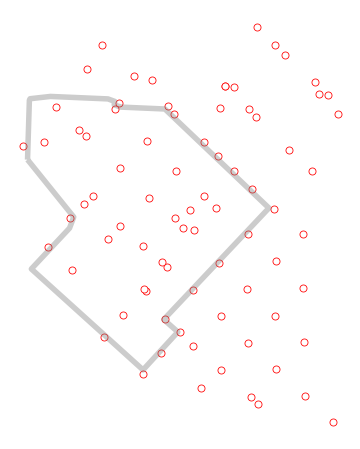

In [55]:
# como podemos apreciar las coberturas son diferentes
f, ax = plt.subplots(figsize=(12,8))
gdf.to_crs(nodes_proj.crs).geometry.boundary.plot(ax=ax, color='grey', linewidth=5.5, alpha=0.4)
nodes_proj.plot(ax=ax, color='white', markersize=50, linewidth=0.8, edgecolor='red')
ax.set_axis_off();

Algo importante para aclarar, es que el calculo de áreas se hace sobre objetos diferentes. Mientras uno utiliza el polígono delimitado, tal como se encuentra en OSM. La cobertura de los nodos toma como base la cantidad de vértices delimitados en nuestro grafo inicial. De ahí la diferencia en metros cuadrados.

In [56]:
stats = ox.basic_stats(G_proj, area=graph_area_m, clean_intersects=True, circuity_dist='euclidean')

In [57]:
stats

{'n': 80,
 'm': 252,
 'k_avg': 6.3,
 'intersection_count': 76,
 'streets_per_node_avg': 3.25,
 'streets_per_node_counts': {0: 0, 1: 4, 2: 1, 3: 46, 4: 29},
 'streets_per_node_proportion': {0: 0.0,
  1: 0.05,
  2: 0.0125,
  3: 0.575,
  4: 0.3625},
 'edge_length_total': 25957.92799999998,
 'edge_length_avg': 103.00765079365073,
 'street_length_total': 12978.964000000005,
 'street_length_avg': 103.00765079365084,
 'street_segments_count': 126,
 'node_density_km': 144.54002363703424,
 'intersection_density_km': 137.31302245518253,
 'edge_density_km': 46899.49408360538,
 'street_density_km': 23449.74704180272,
 'circuity_avg': 1.0881372041136765,
 'self_loop_proportion': 0.0,
 'clean_intersection_count': 65,
 'clean_intersection_density_km': 117.43876920509032}

Para una mirada de mayor profunidad en el módulo de estadísticas de la red, se puede revisar la [documentación oficial](https://osmnx.readthedocs.io/en/stable/osmnx.html#module-osmnx.stats)

## 3.2. Estadísticas extendidas

In [58]:
extended_stats = ox.extended_stats(G, ecc=True, bc=True, cc=True)

In [59]:
for key, value in extended_stats.items():
    stats[key] = value

In [60]:
pd.DataFrame(pd.Series(stats, name='value'))

,value
n,80
m,252
k_avg,6.3
intersection_count,76
streets_per_node_avg,3.25
streets_per_node_counts,"{0: 0, 1: 4, 2: 1, 3: 46, 4: 29}"
streets_per_node_proportion,"{0: 0.0, 1: 0.05, 2: 0.0125, 3: 0.575, 4: 0.3625}"
edge_length_total,25957.928
edge_length_avg,103.007651
street_length_total,12978.964


### EXPLICAR LAS EXTEDED STATS

## betweenness centrality

Explicar betweenness centraluty

In [61]:
max_node, max_bc = max(extended_stats['betweenness_centrality'].items(), key=lambda x: x[1])
max_node, max_bc

(8075787784, 0.25770853618954886)

In the city of Piedmont, California, the node with the highest betweenness centrality has ~30% of all shortest paths running through it. Let's highlight it in the plot:

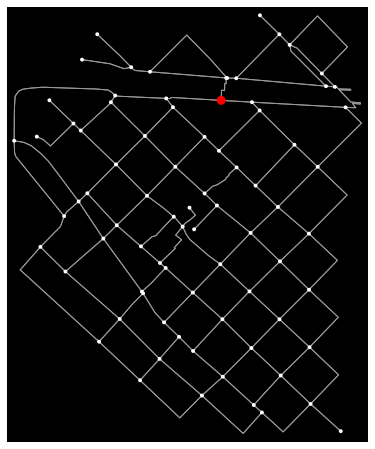

In [62]:
nc = ['r' if node==max_node else 'w' for node in G_proj.nodes()]
ns = [80 if node==max_node else 15 for node in G_proj.nodes()]
fig, ax = ox.plot_graph(G_proj, node_size=ns, node_color=nc, node_zorder=2, bgcolor='k')

~30% of all shortest paths run through the node highlighted in red. Let's look at the relative betweenness centrality of every node in the graph:

In [63]:
import networkx as nx

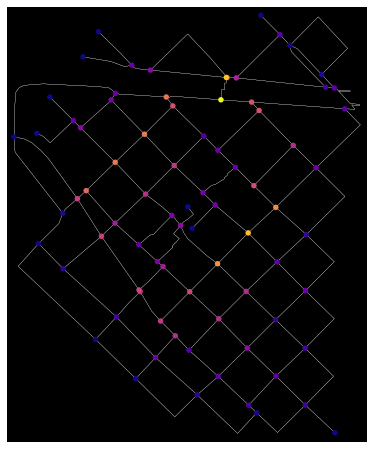

In [64]:
nx.set_node_attributes(G, extended_stats['betweenness_centrality'], 'bc')
nc = ox.plot.get_node_colors_by_attr(G, 'bc', cmap='plasma')
fig, ax = ox.plot_graph(G, node_color=nc, node_size=30, node_zorder=2,
                        edge_linewidth=0.2, edge_color='w', bgcolor='k')

Above, the nodes are visualized by betweenness centrality, from low (dark violet) to high (light yellow). The colors in the colorspace are linearly mapped to the attribute values.

## Visualize street centrality

In [65]:
# convert graph to line graph so edges become nodes and vice versa
edge_centrality = nx.closeness_centrality(nx.line_graph(G))
nx.set_edge_attributes(G, edge_centrality, 'edge_centrality')

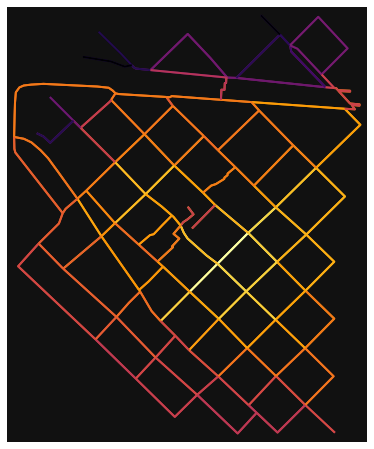

In [66]:
# color edges in original graph with closeness centralities from line graph
ec = ox.plot.get_edge_colors_by_attr(G, 'edge_centrality', cmap='inferno')
fig, ax = ox.plot_graph(G, edge_color=ec, edge_linewidth=2, node_size=0)

## Shortest path routing

Let the origin node be the node nearest the location and let the destination node just be the last node in the network. Then find the shortest path between origin and destination. The edges can be weighted in various different ways, but distance or travel time are the most common approaches.

In [67]:
# punto de referencia desde donde creamos la red
referencia

(-34.50944, -58.5861)

In [68]:
origin_node = ox.get_nearest_node(G, referencia)
destination_node = list(G.nodes())[1]

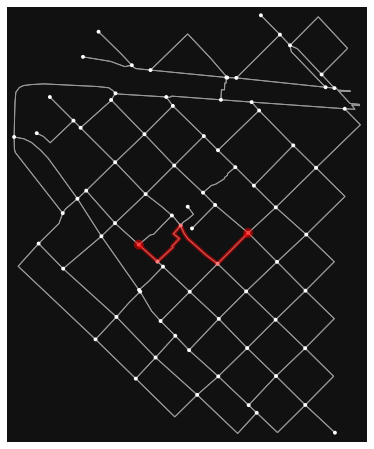

In [69]:
# find the route between these nodes then plot it
route = nx.shortest_path(G, origin_node, destination_node)  # this is a NetworkX function

fig, ax = ox.plot_graph_route(G, route)

## Routing from one lat-lon to another¶

In [70]:
# define origin/desination points then get the nodes nearest to each
origin_point = (37.792896, -122.412325)
destination_point = (37.790495, -122.408353)

origin_node = ox.get_nearest_node(G, origin_point)
destination_node = ox.get_nearest_node(G, destination_point)
origin_node, destination_node

(684325429, 684325429)

In [71]:
# find the shortest path between origin and destination nodes
route = nx.shortest_path(G, origin_node, destination_node, weight='length')
str(route)

'[684325429]'

In [72]:
type(route)

list

In [73]:
# plot the route showing origin/destination lat-long points in blue
fig, ax = ox.plot_graph_route(G, route, origin_point=origin_point, destination_point=destination_point)
fig.show()

TypeError: plot_graph() got an unexpected keyword argument 'origin_point'

# Ejercitación

Descargar la red de calles de:

**a)** Dos asentamientos informales 

**b)** Un asentamiento informal y otro de traza regular

... y compararlas considerando los principales aspectos topológicos de ambas ¿Cómo afectan estos a la movilidad dentro de la red?

*Nota*
Entre los distintos métodos que se revisaron para descargar una red, elegir aquel que garantice la mayor comparabilidad. Asimismo, elegir el conjunto de métricas que mejor describan la movilidad dentro del contexto analizado.